In [1]:
# mount drive, fetch the needful

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
ROOT_DIR="/content/drive/MyDrive/BrowserDaemon/ui-annotations_aug_25_25"

import os, json, pathlib
TRAIN_JSON = os.path.join(ROOT_DIR, "train.json")
VAL_JSON = os.path.join(ROOT_DIR,"val.json")
IMAGES_DIR = os.path.join(ROOT_DIR,"images")

# verify locations
print("train_json exists", os.path.exists(TRAIN_JSON))
print("val_json exists", os.path.exists(VAL_JSON))
print("images_dir exists", os.path.exists(IMAGES_DIR))

from typing import Dict, Any, List

DocType = Dict[str, Any]

def load_coco(path: str) -> DocType:
  with open(path, "r") as f:
    return json.load(f)

train_coco = load_coco(TRAIN_JSON)
val_coco = load_coco(VAL_JSON)
print(train_coco["info"])

Mounted at /content/drive
train_json exists True
val_json exists True
images_dir exists True
{'description': 'UI dataset', 'version': '1.0'}


In [2]:
# install and setup
!pip -q uninstall -y torch torchvision torchaudio

# Install CUDA 12.1 builds (works on recent Colab GPUs)
!pip -q install --index-url https://download.pytorch.org/whl/cu121 torch torchvision

# Install detectron2 (builds against the installed torch/CUDA)
!pip -q install -U 'git+https://github.com/facebookresearch/detectron2.git'
# torch sanity check
import torch, detectron2
print("cuda available", torch.cuda.is_available())
print("torch cuda:", torch.version.cuda, "torch", torch.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 126.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# register our datasets with d2
import os
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog

register_coco_instances("ui_train", {}, TRAIN_JSON, ROOT_DIR)
register_coco_instances("ui_val",   {}, VAL_JSON,   ROOT_DIR)

with open(TRAIN_JSON, "r") as f:
    cats = [c["name"] for c in json.load(f)["categories"]]

MetadataCatalog.get("ui_train").set(thing_classes=cats)
MetadataCatalog.get("ui_val").set(thing_classes=cats)

meta = MetadataCatalog.get("ui_train")
print("Classes:", meta.thing_classes if len(meta.thing_classes) else "inferred from JSON")
print("Val Classes:", MetadataCatalog.get("ui_val").thing_classes)

Classes: ['button', 'heading', 'input']
Val Classes: ['button', 'heading', 'input']


In [12]:
# create our configuration
import os, json, math, torch
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog

# Load categories (for NUM_CLASSES)
with open(TRAIN_JSON, "r") as f:
    train_coco = json.load(f)
cats = [c["name"] for c in train_coco["categories"]]
num_classes = len(cats)

# Count training images for schedule sizing
n_train_images = len(train_coco["images"])
IMS_PER_BATCH = 4          # bump to 8–12 on L4/A100 if you have headroom
EPOCHS = 24                # longer than before, but still reasonable
iters_per_epoch = math.ceil(n_train_images / IMS_PER_BATCH)
MAX_ITER = EPOCHS * iters_per_epoch
STEPS = (int(MAX_ITER * 0.8), int(MAX_ITER * 0.9))  # step LR decay

print("Train images:", n_train_images, "| iters/epoch:", iters_per_epoch, "| max_iter:", MAX_ITER)

cfg = get_cfg()
# Stronger backbone than R50:
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("ui_train",)
cfg.DATASETS.TEST  = ("ui_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# Pretrained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # more stable for small datasets

# Keep default freeze of early stages to stabilize
# cfg.MODEL.BACKBONE.FREEZE_AT = 2  # (default is 2)

# Solver
cfg.SOLVER.IMS_PER_BATCH = IMS_PER_BATCH

cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.SOLVER.STEPS = list(STEPS)
cfg.SOLVER.WARMUP_ITERS = min(1000, max(100, iters_per_epoch))
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.AMP.ENABLED = False

# Evaluate & checkpoint ~once per epoch
cfg.TEST.EVAL_PERIOD = max(200, iters_per_epoch)
cfg.SOLVER.CHECKPOINT_PERIOD = max(200, iters_per_epoch)

# output
cfg.OUTPUT_DIR = os.path.join(ROOT_DIR, "train_output2")
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Enable gradient clipping (full model) to prevent explosions
cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "value"   # valid: "value" | "norm"
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0


Train images: 238 | iters/epoch: 60 | max_iter: 1440


In [13]:
# augmentation mapper to improve training data
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
import torch

def ui_mapper(dataset_dict):
    dataset_dict = dataset_dict.copy()
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    annos = dataset_dict.get("annotations", [])

    aug = T.AugmentationList([
        T.RandomFlip(horizontal=True, vertical=False, prob=0.5),

        # Multi-scale but keep within typical detectron2 defaults
        T.ResizeShortestEdge(
            short_edge_length=(640, 672, 704, 736, 768, 800),
            max_size=1333,
            sample_style="choice"
        ),

        # Gentle crop: at most 10% off each dimension
        T.RandomCrop("relative_range", (0.9, 0.9)),

        # Very light color jitter
        T.RandomBrightness(0.9, 1.1),
        T.RandomContrast(0.9, 1.1),
        T.RandomSaturation(0.9, 1.1),
    ])

    aug_input = T.AugInput(image)
    transforms = aug(aug_input)
    image = aug_input.image

    # Transform annotations and build instances
    annos = [utils.transform_instance_annotations(a, transforms, image.shape[:2])
             for a in annos]
    instances = utils.annotations_to_instances(annos, image.shape[:2])

    # Always filter empty/degenerate instances after aug
    instances = utils.filter_empty_instances(instances)

    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1))
    dataset_dict["instances"] = instances
    return dataset_dict


In [14]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_train_loader
from detectron2.evaluation import COCOEvaluator

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, output_dir=cfg.OUTPUT_DIR)

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=ui_mapper)

trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/26 21:02:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[08/26 21:02:32 d2.engine.train_loop]: Starting training from iteration 0
[08/26 21:02:49 d2.utils.events]:  eta: 0:14:49  iter: 19  total_loss: 2.428  loss_cls: 0.989  loss_box_reg: 0.3219  loss_rpn_cls: 0.927  loss_rpn_loc: 0.236    time: 0.8605  last_time: 1.3134  data_time: 0.2869  last_data_time: 0.7071   lr: 0.00019081  max_mem: 6612M
[08/26 21:03:14 d2.utils.events]:  eta: 0:27:02  iter: 39  total_loss: 1.229  loss_cls: 0.5008  loss_box_reg: 0.4009  loss_rpn_cls: 0.1551  loss_rpn_loc: 0.1549    time: 1.0697  last_time: 1.7042  data_time: 0.6553  last_data_time: 1.0777   lr: 0.00039061  max_mem: 6740M
[08/26 21:03:38 d2.utils.events]:  eta: 0:26:53  iter: 59  total_loss: 1.016  loss_cls: 0.3774  loss_box_reg: 0.4141  loss_rpn_cls: 0.06722  loss_rpn_loc: 0.1406    time: 1.1021  last_time: 0.8218  data_time: 0.5532  last_data_time: 0.2476   lr: 0.00059041  max_mem: 6955M
[08/26 21:03:50 d2.utils.events]:  eta: 0:25:20  iter: 79  total_loss: 1.056  loss_cls: 0.3638  loss_box_reg: 0.

# Visualize model predictions

[08/26 21:38:10 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/BrowserDaemon/ui-annotations_aug_25_25/train_output2/model_final.pth ...


/usr/local/lib/python3.12/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

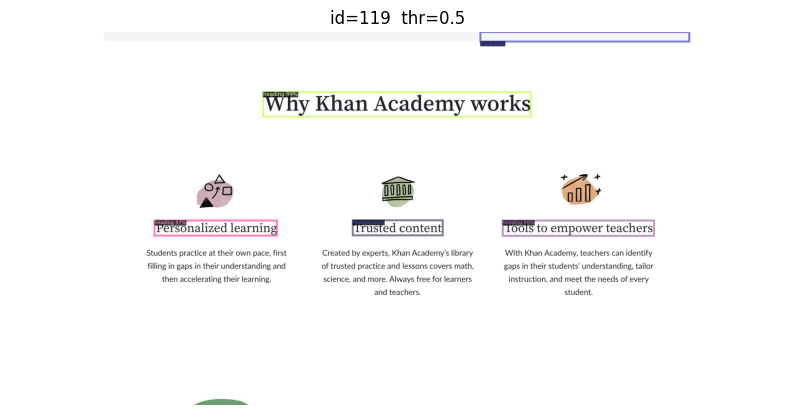

In [22]:
import os, json, random, cv2, matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# --- Paths ---
WEIGHTS    = os.path.join(ROOT_DIR, "train_output2", "model_final.pth")

assert os.path.exists(WEIGHTS), f"Missing weights: {WEIGHTS}"

# --- Build cfg for inference (same arch as training) ---
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
# match your training datasets and num classes
cats = [c["name"] for c in val_coco["categories"]]
MetadataCatalog.get("ui_val").set(thing_classes=cats)
cfg.DATASETS.TEST = ("ui_val",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(cats)
cfg.MODEL.WEIGHTS = WEIGHTS
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # adjust threshold if you want more/less boxes
# If you trained on CPU, uncomment:
# cfg.MODEL.DEVICE = "cpu"

predictor = DefaultPredictor(cfg)

# --- Pick a val image and run inference ---
def show_prediction(index_in_doc=0, figsize=(10,7)):
    im_meta = val_coco["images"][index_in_doc % len(val_coco["images"])]
    img_path = os.path.join(ROOT_DIR, im_meta["file_name"])
    assert os.path.exists(img_path), f"Missing image: {img_path}"
    im = cv2.imread(img_path)

    outputs = predictor(im)  # dict with "instances"
    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("ui_val"), scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=figsize)
    plt.imshow(out.get_image())
    plt.title(f"id={im_meta['id']}  thr={cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST}")
    plt.axis("off")
    plt.show()

# Example: fixed index
# show_prediction(index_in_doc=0)

# Or try a random sample:
show_prediction(index_in_doc=random.randrange(len(val_coco["images"])))